In [37]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import seaborn as sns
import numpy as np

from src import datasets, metrics

In [38]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [51]:
# data paths
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [52]:
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [53]:
train_df.value_counts('target')

target
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

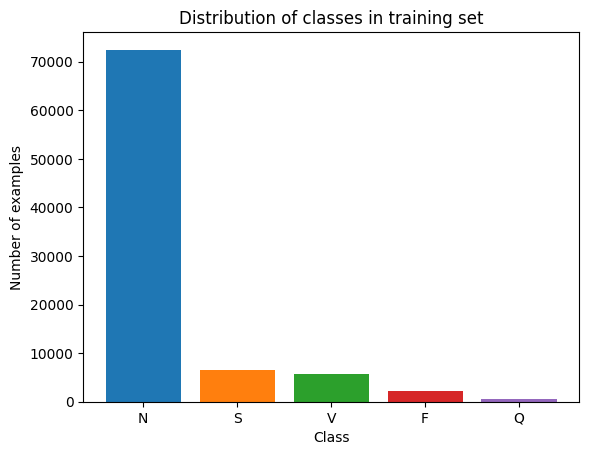

In [54]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = ['N', 'S', 'V', 'F', 'Q']
plt.bar(class_names, train_df.target.value_counts(), color = colors)

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Distribution of classes in training set')
plt.show()

In [71]:
class_0 = train_df[train_df['target'] == 0]
class_0.shape
len(class_0)*0.75

54353.25

In [72]:
class_0 = train_df[train_df['target'] == 0]  # e.g., normal heartbeats
class_1 = train_df[train_df['target'] == 1]  
class_2 = train_df[train_df['target'] == 2]
class_3 = train_df[train_df['target'] == 3]
class_4 = train_df[train_df['target'] == 4]

# Determine the desired number of samples for each class
n_samples = 55000
print(n_samples)

# Downsample class 0
class_0_downsampled = resample(class_0, 
                               replace=False,  # sample without replacement
                               n_samples=n_samples,  # match number of samples in minority classes
                               random_state=42)  # reproducible results


55000


In [81]:
class_0 = train_df[train_df['target'] == 0]  # e.g., normal heartbeats
class_1 = train_df[train_df['target'] == 1]  
class_2 = train_df[train_df['target'] == 2]
class_3 = train_df[train_df['target'] == 3]
class_4 = train_df[train_df['target'] == 4]

# Determine the desired number of samples for each class
n_samples = 55000

# Downsample class 0
class_0_downsampled = resample(class_0, 
                               replace=False,  # sample without replacement
                               n_samples=n_samples,  # match number of samples in minority classes
                               random_state=42)  # reproducible results

# Upsample classes 1, 2, 3, and 4
class_1_upsampled = resample(class_1, 
                             replace=True,  # sample with replacement
                             n_samples=n_samples,  # match number of samples in minority classes
                             random_state=42)  # reproducible results

class_2_upsampled = resample(class_2, 
                             replace=True, 
                             n_samples=n_samples, 
                             random_state=42)

class_3_upsampled = resample(class_3, 
                             replace=True, 
                             n_samples=n_samples, 
                             random_state=42)

class_4_upsampled = resample(class_4, 
                             replace=True, 
                             n_samples=n_samples, 
                             random_state=42)

# Combine the resampled classes
df_oversampled_all = pd.concat([class_0_downsampled, class_1_upsampled, class_2_upsampled, class_3_upsampled, class_4_upsampled])
#save oversampled data
#df_oversampled_all.to_parquet(datadir / 'heart_big_oversampled_full_train.parq')


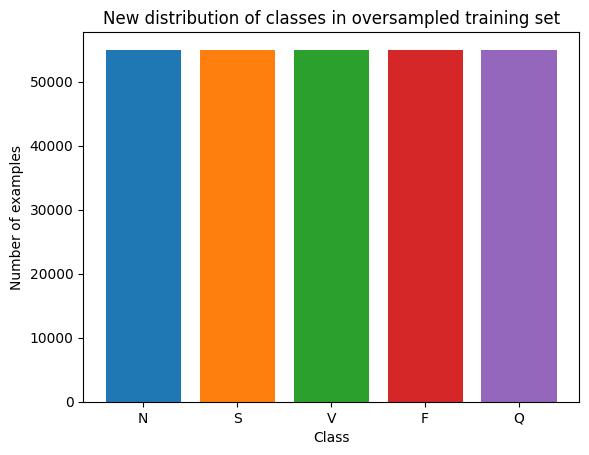

In [82]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = ['N', 'S', 'V', 'F', 'Q']
plt.bar(class_names, df_oversampled_all.target.value_counts(), color = colors)

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('New distribution of classes in oversampled training set')
plt.show()

In [13]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = train_df[train_df['target'] == 0]  # e.g., normal heartbeats
minority_class = train_df[train_df['target'] != 0]  # e.g., abnormal heartbeats
print('Majority class:', len(majority_class))
print('Minority class:', len(minority_class))

# Oversample the minority class
minority_oversampled = resample(minority_class, 
                                replace=True,      # Sample with replacement
                                n_samples=len(majority_class),  # Make the minority class as large as majority class
                                random_state=42)   # For reproducibility
print('Oversampled minority class:', len(minority_oversampled))

# Combine the majority class with the oversampled minority class
df_oversampled = pd.concat([majority_class, minority_oversampled])

# Shuffle the dataset to randomize the order
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)
#df_oversampled.to_parquet(datadir / 'heart_big_oversampled_train.parq')



Majority class: 72471
Minority class: 15083
Oversampled minority class: 72471


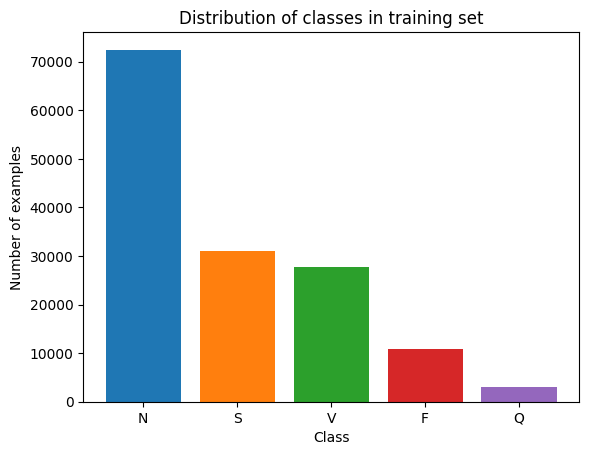

In [ ]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = ['N', 'S', 'V', 'F', 'Q']
plt.bar(class_names, df_oversampled.target.value_counts(), color = colors)

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('Distribution of classes in training set')
plt.show()

In [27]:
train_df = df_oversampled.copy()

In [28]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = train_df[train_df['target'] == 0]  # e.g., normal heartbeats
minority_class = train_df[train_df['target'] == 4]  # e.g., abnormal heartbeats
print('Majority class:', len(majority_class))
print('Minority class:', len(minority_class))

# Oversample the minority class
minority_oversampled = resample(minority_class, 
                                replace=True,      # Sample with replacement
                                n_samples=len(majority_class),  # Make the minority class as large as majority class
                                random_state=42)   # For reproducibility
print('Oversampled minority class:', len(minority_oversampled))

# Combine the majority class with the oversampled minority class
df_oversampled = pd.concat([train_df, minority_oversampled])

# Shuffle the dataset to randomize the order
df_oversampled = df_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)
#df_oversampled.to_parquet(datadir / 'heart_big_oversampled_train.parq')


Majority class: 72471
Minority class: 30938
Oversampled minority class: 72471


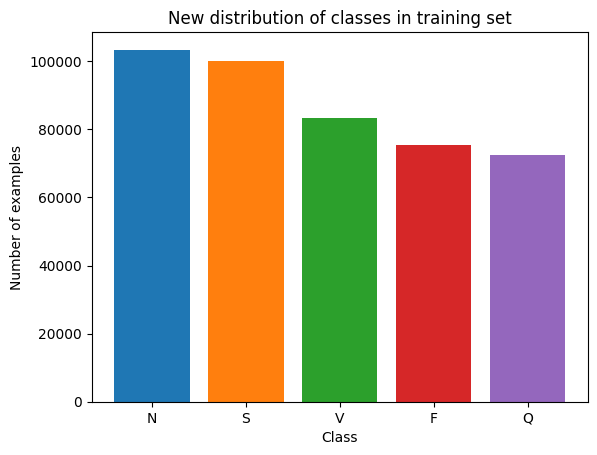

In [ ]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
class_names = ['N', 'S', 'V', 'F', 'Q']
plt.bar(class_names, df_oversampled.target.value_counts(), color = colors)

plt.xlabel('Class')
plt.ylabel('Number of examples')
plt.title('New distribution of classes in training set')
plt.show()

In [30]:
df_oversampled.to_parquet(datadir / 'heart_big_oversampled_all_train.parq')

In [5]:
trainfile = datadir / (config['arrhythmia'] + '_oversampled_train.parq')

In [6]:
#loading the datasets 
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 144942), Heartdataset (len 21892))

In [7]:
x, y = traindataset[0]
x.shape
# 192 bestaat uit 187 data punten en 5 classes of zijn dat channels?

torch.Size([192, 1])